In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [54]:
d90_file = '../results/complexity_utf-16_10_10_1234_bibles_90_lcm.csv'
dall_file = '../results/complexity_utf-16_10_10_1234_bibles_lcm.csv'

# Carregar o arquivo original
original_file1 = '../dataset/bibles_lcm.csv'
original_file2 = '../dataset/bibles_90_lcm.csv'
df_original1 = pd.read_csv(original_file1)
df_original2 = pd.read_csv(original_file2)

# Calcular o tamanho do texto por língua
text_sizes_90_lcm = df_original1.groupby('language')['text'].apply(lambda x: sum(len(text) for text in x)).reset_index()
text_sizes_90_lcm = text_sizes_90_lcm.rename(columns={'text': 'text_size'})

text_sizes_lcm = df_original1.groupby('language')['text'].apply(lambda x: sum(len(text) for text in x)).reset_index()
text_sizes_lcm = text_sizes_lcm.rename(columns={'text': 'text_size'})


df90 = pd.read_csv(d90_file, index_col=False)
df90 = df90[df90.language != 'NAMBIKUÁRA'] # We removed Nambikuára because it has tone annotation
#df90.loc[df90.metric == 'del-chars', 'value'] = - df90.loc[df90.metric == 'del-chars', 'value']

dfall = pd.read_csv(dall_file, index_col=False)
dfall = dfall[dfall.language != 'NAMBIKUÁRA'] # We removed Nambikuára because it has tone annotation
#dfall.loc[dfall.metric == 'del-chars', 'value'] = - dfall.loc[dfall.metric == 'del-chars', 'value']

df90 = df90.merge(text_sizes_90_lcm, on='language', how='left')
dfall = dfall.merge(text_sizes_lcm, on='language', how='left')

family = pd.read_csv('../dataset/family.csv', index_col=None)

In [55]:
def compute(dfi, alg):
    df = dfi.copy()
    ag = df.algorithm == alg
    dw = df.metric == 'del-words'
    dc = df.metric == 'del-chars'
    
    x = df[dw & ag].groupby(['language', 'algorithm']).value.transform('mean').to_numpy()
    y = df[dc & ag].groupby(['language', 'algorithm']).value.transform('mean').to_numpy()

    df.loc[dw & ag, 'del-words'] = x
    df.loc[dw & ag, 'del-chars'] = y
    df = df.dropna().drop_duplicates('language').reset_index().drop(columns=['metric', 'index', 'run_id'])

    return df

/tmp/ipykernel_23381/282791041.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[di].scatter(
/tmp/ipykernel_23381/282791041.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[di].scatter(
/tmp/ipykernel_23381/282791041.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[di].set_xticklabels(ax[di].get_xticklabels(), fontsize=20)
/tmp/ipykernel_23381/282791041.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[di].set_yticklabels(ax[di].get_yticklabels(), fontsize=20)
/tmp/ipykernel_23381/282791041.py:45: User

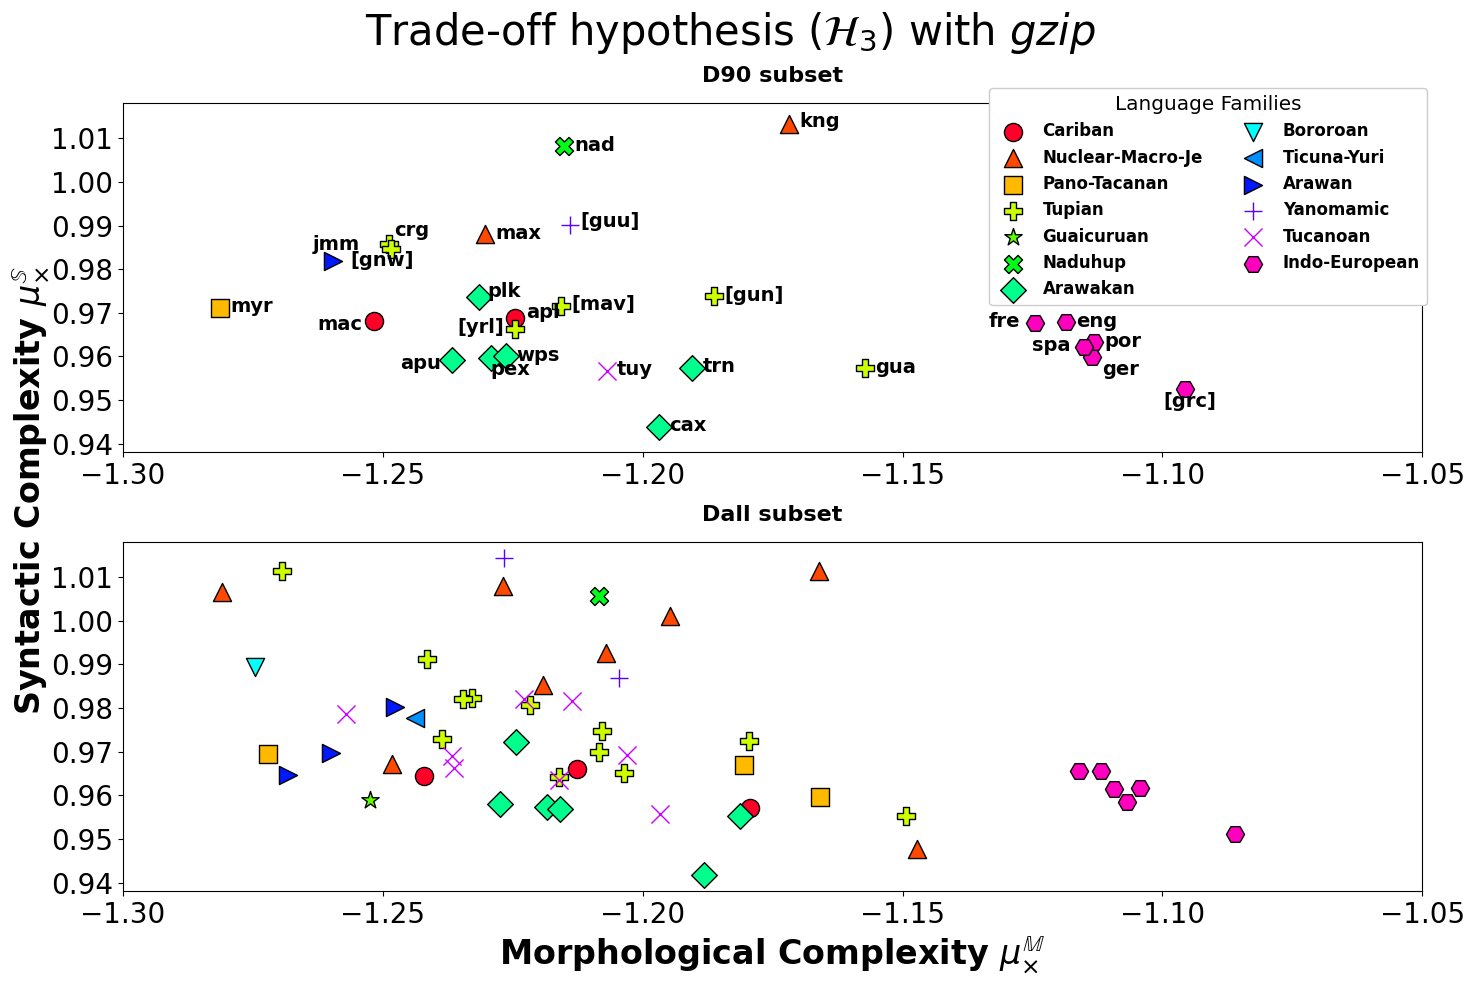

In [52]:
def plot(df90, dfall, algo, family, wals=None, text=False):

    def process_df(df, algo, wals):
        wals = wals or set(df.wals)
        df = compute(df[df.wals.isin(wals)], algo)
        df = df.merge(family[['wals', 'family_glottocode']], on='wals', how='left')
        return df

    def create_color_marker_dicts(df1, df2, families):
        unique_families = list(set(families.unique()))
        colors = plt.cm.gist_rainbow(np.linspace(0.0, 1, len(unique_families)))
        markers = ['o', '^', 's', 'P', '*', 'X', 'D', 'v', '<', '>', '+', 'x', 'H', '1', '2', '3', '4', '8', '|', '_']
        family_to_color = { f: colors[i] for i, f in enumerate(unique_families)}
        family_to_marker = { f : markers[i] for i, f in enumerate(unique_families)}
        return unique_families, (colors, family_to_color), (markers, family_to_marker)

    def set_color_marker(df, family_to_color, family_to_marker): 
        df['color'] = df['family_glottocode'].map(family_to_color)
        df['marker'] = df['family_glottocode'].map(family_to_marker)
        return df

    # process
    df90 = process_df(df90, algo, wals)
    dfall = process_df(dfall, algo, wals)

    unique_families, (colors, f2c), (markers, f2m) = create_color_marker_dicts(df90, dfall, dfall['family_glottocode'])

    df90 = set_color_marker(df90, f2c, f2m)
    dfall = set_color_marker(dfall, f2c, f2m)
    
    
    fig, ax = plt.subplots(2, 1, figsize=(15,  10), sharex=False, sharey=True)
    fig.suptitle(r"Trade-off hypothesis ($\mathcal{H}_3$) with $\it{%s}$" % (algo.lower(),), fontsize=30)
    fig.supylabel(r'Syntactic Complexity $\mu^{\mathbb{S}}_{\times}$', weight='bold', fontsize=24)
    titles = ['D90 subset', 'Dall subset']
    for di, df in enumerate([df90, dfall]):
        x = df['del-chars'].to_numpy()
        y = df['del-words'].to_numpy()
        l = df['wals'].to_numpy()
        # c = df['color'].to_numpy()
        ax[di].set_xlim((-1.30, -1.05))
        for i, f in enumerate(unique_families):
            df_family = df[df['family_glottocode'] == f]
            if len(df_family):
                ax[di].scatter(
                    df_family['del-chars'],
                    df_family['del-words'],
                    c=[colors[i]],
                    marker=markers[i],
                    edgecolor='black',
                    linewidth=1,
                    label=f if di == 1 else "",
                    s=170,
                )
        if di == 1: ax[di].set_xlabel(r'Morphological Complexity $\mu^{\mathbb{M}}_{\times}$', weight='bold', fontsize=24)
        ax[di].set_title(titles[di], fontsize=16, weight='bold', pad=15)
        
        ax[di].set_xticklabels(ax[di].get_xticklabels(), fontsize=20)
        ax[di].set_yticklabels(ax[di].get_yticklabels(), fontsize=20)
        if di == 0:
            delta = 1e-3
            rot = 0
            dec = lambda u, f: u - f*delta
            inc = lambda u, f: u + f*delta
            for xi, yi, li in zip(x, y, l):
                match li :
                    case "[gnw]":
                        xi = dec(xi, 8)
                        yi = dec(yi, 4)
                    case "crg":
                        xi = inc(xi, 1)
                        yi = inc(yi, 2)
                    case "fre":
                        xi = dec(xi, 9.0)
                        yi = dec(yi, 1.0)
                    case "spa":
                        xi = dec(xi, 10)
                        yi = dec(yi, 1)
                    case "ger":
                        xi = inc(xi, 2)
                        yi = dec(yi, 4)
                    case "[yrl]":
                        yi = dec(yi, 1)
                        xi = dec(xi, 11)
                    case "apu":
                        xi = dec(xi, 10)
                        yi = dec(yi, 2)
                    case "[grc]":
                        xi = dec(xi, 4)
                        yi = dec(yi, 4)
                    case "apl":
                        xi = inc(xi, 2)
                    case "plk":
                        xi = inc(xi, 1.5)
                    case "jmm":
                        xi = dec(xi, 4)
                        yi = inc(yi, 2.5)
                    case "pex":
                        yi = dec(yi, 4)
                        xi = inc(xi, 0)
                    case "wps":
                        yi = dec(yi, 1)
                        xi = inc(xi, 2)
                    case "[guu]":
                        xi = inc(xi, 2)
                        yi = dec(yi, 0.5)
                    case "kng":
                        xi = inc(xi, 2)
                        yi = dec(yi, 0.5)
                    case "mac":
                        xi = dec(xi, 11)
                        yi = dec(yi, 2)
                    case _:
                        xi = inc(xi, 2)
                        yi = dec(yi, 1)
                ax[di].text(xi, yi, li, rotation=rot, fontsize=14, weight='bold')
    #legend = fig.legend(title="Language Families (from Glottolog)", fontsize=20, bbox_to_anchor=(0.386, 0.3475, 0.5805, 0.5905), ncol=2, prop={'weight' : 'bold'})
    legend = fig.legend(title="Language Families", loc='upper right', ncol=2, bbox_to_anchor=(0.97, 0.91), prop={'weight' : 'bold', 'size' : 'large'})
    #legend = fig.legend(fontsize=12, bbox_to_anchor=(0.4, 0.3, 0.58, 0.600), ncol=3, prop={'weight' : 'bold'})
    legend.get_frame().set_alpha(None)
    legend.get_title().set_fontsize('x-large')
    fig.tight_layout()
    fig.savefig("../images/h3.pdf")

plot(df90, dfall, 'gzip', family=family, text=True)

Text sizes for 90_lcm:
                    language  text_size
0              ANCIENT_GREEK     752059
1                    APALAÍ    1278319
2                    APURINÃ    1262528
3                  ASHENINKA    1091658
4                    ENGLISH     848604
5                     FRENCH     890409
6                    GERMANY     892860
7   GUARANI_EASTERN_BOLIVIAN    1071058
8               GUARANI_MBYA     935425
9           GUARANI_PARAGUAY     865353
10  GUARANI_WESTERN_BOLIVIAN    1062561
11                  JAMAMADI    1078104
12                   KAIGANG    1132384
13                   MACUSHI    1505727
14                    MATSÉS    1477178
15                  MAXAKALI    1087776
16                     NADEB    1313835
17                 NHEENGATU     945729
18                   PALIKÚR    1457500
19                   PARECÍS    1188950
20                PORTUGUESE     793782
21               SATERÉ-MAWÉ    1881157
22                   SPANISH     909016
23               

/tmp/ipykernel_23381/1326378509.py:164: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0, di].scatter(
/tmp/ipykernel_23381/1326378509.py:164: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0, di].scatter(
/tmp/ipykernel_23381/1326378509.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, di].set_xticklabels(ax[0, di].get_xticklabels(), fontsize=12, color='white')
/tmp/ipykernel_23381/1326378509.py:188: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, di].set_yticklabels(ax[0, di].get_yticklabels(), fontsize=12, c

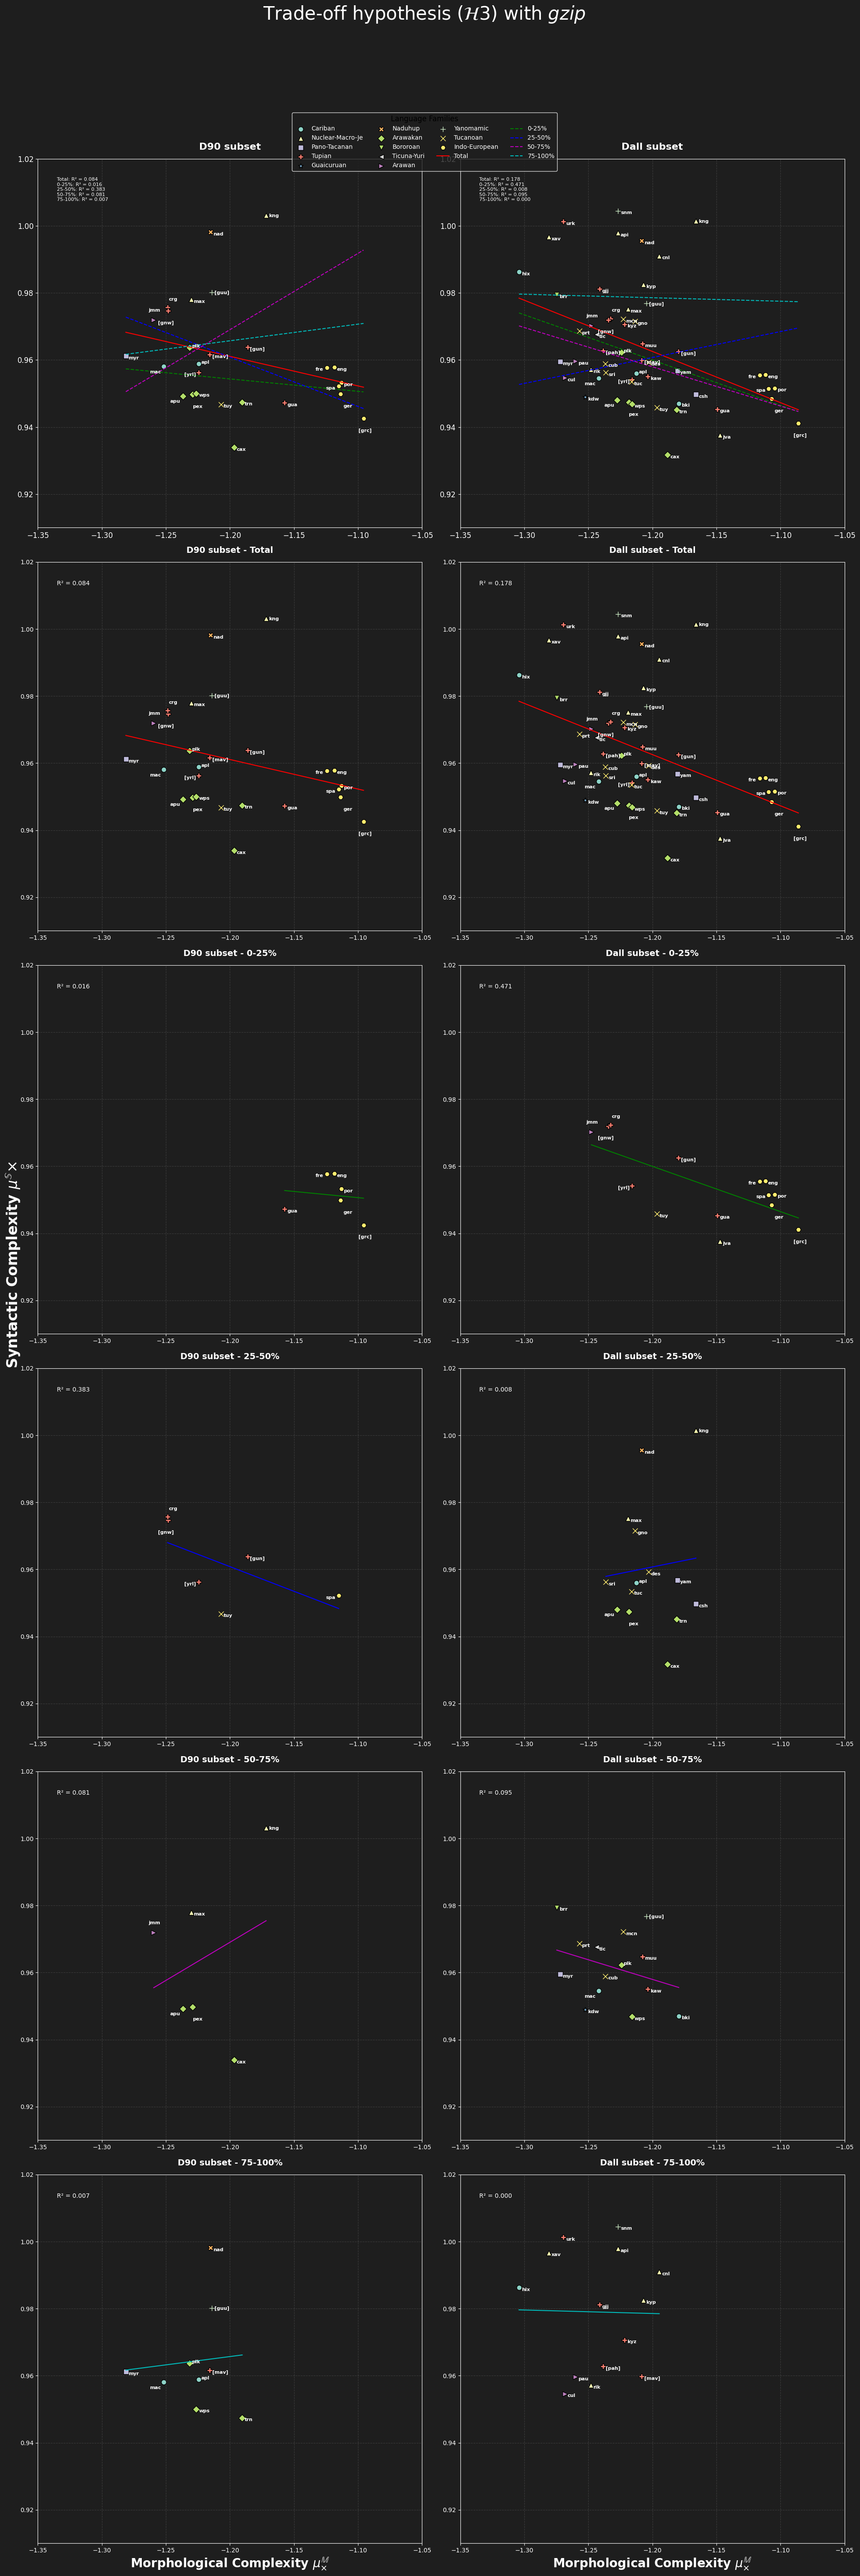

In [59]:
def compute(dfi, alg, text_sizes, family):
    df = dfi.copy()
    ag = df.algorithm == alg
    dw = df.metric == 'del-words'
    dc = df.metric == 'del-chars'
    
    x = df[dw & ag].groupby(['language', 'algorithm']).value.transform('mean').to_numpy()
    y = df[dc & ag].groupby(['language', 'algorithm']).value.transform('mean').to_numpy()

    df.loc[dw & ag, 'del-words'] = x
    df.loc[dw & ag, 'del-chars'] = y
    df = df.dropna().drop_duplicates('language').reset_index().drop(columns=['metric', 'index', 'run_id'])
    
    # Adicionar a informação de text_size
    df = df.merge(text_sizes, on='language', how='left')
    
    # Adicionar a informação de family_glottocode
    df = df.merge(family[['wals', 'family_glottocode']], on='wals', how='left')

    return df

def calculate_regression(x, y):
    slope, intercept, r_value, _, _ = stats.linregress(x, y)
    r_squared = r_value**2
    return slope, intercept, r_squared

def plot_regression(df90, dfall, algo, family, text_sizes_90, text_sizes_all, wals=None, text=False):
    def process_df(df, algo, wals, text_sizes):
        wals = wals or set(df.wals)
        df = compute(df[df.wals.isin(wals)], algo, text_sizes, family)
        return df

    def create_color_marker_dicts(df1, df2, families):
        unique_families = list(set(families.unique()))
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_families)))
        markers = ['o', '^', 's', 'P', '*', 'X', 'D', 'v', '<', '>', '+', 'x', 'H', '1', '2', '3', '4', '8', '|', '_']
        family_to_color = {f: colors[i] for i, f in enumerate(unique_families)}
        family_to_marker = {f: markers[i] for i, f in enumerate(unique_families)}
        return unique_families, (colors, family_to_color), (markers, family_to_marker)

    def set_color_marker(df, family_to_color, family_to_marker):
        df['color'] = df['family_glottocode'].map(family_to_color)
        df['marker'] = df['family_glottocode'].map(family_to_marker)
        return df

    def calculate_regressions(df):
        x = df['del-chars'].to_numpy()
        y = df['del-words'].to_numpy()
        
        slope_total, intercept_total, r2_total = calculate_regression(x, y)
        
        if 'text_size' not in df.columns:
            print("Warning: 'text_size' column not found. Using equal-sized quartiles instead.")
            df['text_size'] = 1  # Use equal sizes if 'text_size' is not available
        
        if 'family_glottocode' not in df.columns:
            print("Warning: 'family_glottocode' column not found. Using placeholder values.")
            df['family_glottocode'] = 'Unknown'
        
        # Ordenar o DataFrame pelo tamanho do texto
        df_sorted = df.sort_values('text_size', ascending=True)
        
        # Calcular o número de línguas em cada quartil
        n_languages = len(df_sorted)
        quartile_size = n_languages // 4
        
        quartiles = []
        
        for i in range(4):
            start = i * quartile_size
            end = (i + 1) * quartile_size if i < 3 else n_languages
            
            df_quartile = df_sorted.iloc[start:end]
            
            print(f"\nQuartil {i+1}:")
            for _, row in df_quartile.iterrows():
                print(f"Língua: {row['language']}, Tamanho do texto: {row['text_size']}")
            
            x_q = df_quartile['del-chars'].to_numpy()
            y_q = df_quartile['del-words'].to_numpy()
            
            if len(x_q) > 1 and len(y_q) > 1:
                slope_q, intercept_q, r2_q = calculate_regression(x_q, y_q)
            else:
                slope_q, intercept_q, r2_q = 0, 0, 0
            
            quartiles.append((slope_q, intercept_q, r2_q, df_quartile))
        
        return slope_total, intercept_total, r2_total, quartiles, df_sorted


    def add_labels(ax, x, y, labels):
        delta = 1e-3
        rot = 0
        dec = lambda u, f: u - f*delta
        inc = lambda u, f: u + f*delta
        for xi, yi, li in zip(x, y, labels):
            match li:
                case "[gnw]":
                    xi = dec(xi, 8); yi = dec(yi, 4)
                case "crg":
                    xi = inc(xi, 1); yi = inc(yi, 2)
                case "fre":
                    xi = dec(xi, 9.0); yi = dec(yi, 1.0)
                case "spa":
                    xi = dec(xi, 10); yi = dec(yi, 1)
                case "ger":
                    xi = inc(xi, 2); yi = dec(yi, 4)
                case "[yrl]":
                    yi = dec(yi, 1); xi = dec(xi, 11)
                case "apu":
                    xi = dec(xi, 10); yi = dec(yi, 2)
                case "[grc]":
                    xi = dec(xi, 4); yi = dec(yi, 4)
                case "apl":
                    xi = inc(xi, 2)
                case "plk":
                    xi = inc(xi, 1.5)
                case "jmm":
                    xi = dec(xi, 4); yi = inc(yi, 2.5)
                case "pex":
                    yi = dec(yi, 4); xi = inc(xi, 0)
                case "wps":
                    yi = dec(yi, 1); xi = inc(xi, 2)
                case "[guu]":
                    xi = inc(xi, 2); yi = dec(yi, 0.5)
                case "kng":
                    xi = inc(xi, 2); yi = dec(yi, 0.5)
                case "mac":
                    xi = dec(xi, 11); yi = dec(yi, 2)
                case _:
                    xi = inc(xi, 2); yi = dec(yi, 1)
            ax.text(xi, yi, li, rotation=rot, fontsize=8, weight='bold', color='white')

    df90 = process_df(df90, algo, wals, text_sizes_90)
    dfall = process_df(dfall, algo, wals, text_sizes_all)
    unique_families, (colors, f2c), (markers, f2m) = create_color_marker_dicts(df90, dfall, dfall['family_glottocode'])
    df90 = set_color_marker(df90, f2c, f2m)
    dfall = set_color_marker(dfall, f2c, f2m)

    reg_90 = calculate_regressions(df90)
    reg_all = calculate_regressions(dfall)

    fig, ax = plt.subplots(6, 2, figsize=(20, 60), facecolor='#1e1e1e')
    fig.suptitle(r"Trade-off hypothesis ($\mathcal{H}3$) with $\it{%s}$" % (algo.lower(),), fontsize=30, color='white')
    fig.subplots_adjust(top=0.95)
    fig.supylabel(r'Syntactic Complexity $\mu^{\mathbb{S}}{\times}$', weight='bold', fontsize=24, color='white')
    titles = ['D90 subset', 'Dall subset']

    for di, (df, reg) in enumerate(zip([df90, dfall], [reg_90, reg_all])):
        x = df['del-chars'].to_numpy()
        y = df['del-words'].to_numpy()
        l = df['wals'].to_numpy()
        #c = df['color'].to_numpy()

        ax[0, di].set_facecolor('#1e1e1e')
        ax[0, di].set_xlim((-1.35, -1.05))
        ax[0, di].set_ylim((0.91, 1.02))
        ax[0, di].grid(True, linestyle='--', alpha=0.3, color='gray')

        for i, f in enumerate(unique_families):
            df_family = df[df['family_glottocode'] == f]
            if len(df_family):
                ax[0, di].scatter(
                    df_family['del-chars'],
                    df_family['del-words'],
                    c=[colors[i]],
                    marker=markers[i],
                    edgecolor='black',
                    linewidth=1,
                    label=f,
                    s=70,
                )
                
        slope, intercept, r2 = reg[0], reg[1], reg[2]
        x_range = np.linspace(x.min(), x.max(), 100)
        ax[0, di].plot(x_range, slope * x_range + intercept, 'r-', label=f'Total')

        quartile_colors = ['g', 'b', 'm', 'c']
        quartile_labels = ['0-25%', '25-50%', '50-75%', '75-100%']
        for i, (slope_q, intercept_q, r2_q, _) in enumerate(reg[3]):
            ax[0, di].plot(x_range, slope_q * x_range + intercept_q, f'{quartile_colors[i]}--', 
                        label=f'{quartile_labels[i]}')

        ax[0, di].set_title(titles[di], fontsize=16, weight='bold', pad=15, color='white')
        ax[0, di].tick_params(colors='white')
        ax[0, di].set_xticklabels(ax[0, di].get_xticklabels(), fontsize=12, color='white')
        ax[0, di].set_yticklabels(ax[0, di].get_yticklabels(), fontsize=12, color='white')

        for spine in ax[0, di].spines.values():
            spine.set_edgecolor('white')

        add_labels(ax[0, di], x, y, l)

        r2_text = f"Total: R² = {reg[2]:.3f}\n"
        for i, (_, _, r2_q, _) in enumerate(reg[3]):
            r2_text += f"{quartile_labels[i]}: R² = {r2_q:.3f}\n"
        ax[0, di].text(0.05, 0.95, r2_text, transform=ax[0, di].transAxes, fontsize=8,
                    verticalalignment='top', color='white')

        # Plots para cada quartil e total
        for i in range(5):
            if i == 0:
                df_quartile = reg[4]  # df_sorted
                title = f"{titles[di]} - Total"
                color = 'r'
            else:
                df_quartile = reg[3][i-1][3]  # Quartil específico
                title = f"{titles[di]} - {quartile_labels[i-1]}"
                color = quartile_colors[i-1]
        
            ax_q = ax[i+1, di]
            ax_q.set_facecolor('#1e1e1e')
            ax_q.set_xlim((-1.35, -1.05))
            ax_q.set_ylim((0.91, 1.02))
            ax_q.grid(True, linestyle='--', alpha=0.3, color='gray')
        
            if 'family_glottocode' in df_quartile.columns:
                for j, f in enumerate(unique_families):
                    df_family = df_quartile[df_quartile['family_glottocode'] == f]
                    if len(df_family):
                        ax_q.scatter(
                            df_family['del-chars'],
                            df_family['del-words'],
                            c=[colors[j]],
                            marker=markers[j],
                            edgecolor='black',
                            linewidth=1,
                            s=70,
                        )
            else:
                print(f"Warning: 'family_glottocode' not found in quartile {i}")
        
            x_q = df_quartile['del-chars'].to_numpy()
            y_q = df_quartile['del-words'].to_numpy()
            l_q = df_quartile['wals'].to_numpy() if 'wals' in df_quartile.columns else []
            
            if len(x_q) > 1 and len(y_q) > 1:
                slope_q, intercept_q, r2_q = calculate_regression(x_q, y_q)
                x_range = np.linspace(x_q.min(), x_q.max(), 100)
                ax_q.plot(x_range, slope_q * x_range + intercept_q, color=color, linestyle='-')
            else:
                r2_q = 0
        
            ax_q.set_title(title, fontsize=14, weight='bold', pad=15, color='white')
            ax_q.tick_params(colors='white')
            ax_q.set_xticklabels(ax_q.get_xticklabels(), fontsize=10, color='white')
            ax_q.set_yticklabels(ax_q.get_yticklabels(), fontsize=10, color='white')
        
            for spine in ax_q.spines.values():
                spine.set_edgecolor('white')
        
            ax_q.text(0.05, 0.95, f"R² = {r2_q:.3f}", transform=ax_q.transAxes, fontsize=10,
                      verticalalignment='top', color='white')
        
            if len(l_q) > 0:
                add_labels(ax_q, x_q, y_q, l_q)
        
            if i == 4:
                ax_q.set_xlabel(r'Morphological Complexity $\mu^{\mathbb{M}}_{\times}$', weight='bold', fontsize=20, color='white')

    handles, labels = ax[0, 1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), 
               loc='upper center', 
               bbox_to_anchor=(0.5, 0.94),
               fontsize='medium',
               ncol=4,  
               title="Language Families",
               title_fontsize='large',
               facecolor='#1e1e1e',
               edgecolor='white',
               labelcolor='white')
    
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    fig.savefig("../images/h3_with_regressions_extended.pdf", bbox_inches='tight', facecolor='#1e1e1e')


original_file1 = '../dataset/bibles_lcm.csv'
original_file2 = '../dataset/bibles_90_lcm.csv'
df_original1 = pd.read_csv(original_file1)
df_original2 = pd.read_csv(original_file2)

# Calcular o tamanho do texto por língua
text_sizes_90_lcm = df_original2.groupby('language')['text'].apply(lambda x: sum(len(text) for text in x)).reset_index()
text_sizes_90_lcm = text_sizes_90_lcm.rename(columns={'text': 'text_size'})

text_sizes_lcm = df_original1.groupby('language')['text'].apply(lambda x: sum(len(text) for text in x)).reset_index()
text_sizes_lcm = text_sizes_lcm.rename(columns={'text': 'text_size'})

print("Text sizes for 90_lcm:")
print(text_sizes_90_lcm)
print("\nText sizes for lcm:")
print(text_sizes_lcm)

df90 = pd.read_csv(d90_file, index_col=False)
df90 = df90[df90.language != 'NAMBIKUÁRA'] # We removed Nambikuára because it has tone annotation
#df90.loc[df90.metric == 'del-chars', 'value'] = - df90.loc[df90.metric == 'del-chars', 'value']

dfall = pd.read_csv(dall_file, index_col=False)
dfall = dfall[dfall.language != 'NAMBIKUÁRA'] # We removed Nambikuára because it has tone annotation
#dfall.loc[dfall.metric == 'del-chars', 'value'] = - dfall.loc[dfall.metric == 'del-chars', 'value']

family = pd.read_csv('../dataset/family.csv', index_col=None)

# Chamar a função plot_regression com os dois conjuntos de text_sizes
plot_regression(df90, dfall, 'gzip', family=family, text_sizes_90=text_sizes_90_lcm, text_sizes_all=text_sizes_lcm, text=True)





In [18]:
# Carregando os dados necessários
bibles_lcm_file = '../dataset/bibles_lcm.csv'
bibles_90_lcm_file = '../dataset/bibles_90_lcm.csv'

df_lcm = pd.read_csv(bibles_lcm_file)
df_90_lcm = pd.read_csv(bibles_90_lcm_file)

# Inspecionar os primeiros registros dos dataframes
print("Colunas de df_90_lcm:")
print(df_90_lcm.columns)
print("\nPrimeiras linhas de df_90_lcm:")
print(df_90_lcm.head())

print("\nColunas de df_lcm:")
print(df_lcm.columns)
print("\nPrimeiras linhas de df_lcm:")
print(df_lcm.head())

Colunas de df_90_lcm:
Index(['book', 'chapter', 'language', 'language_wals_code', 'verse_number',
       'text'],
      dtype='object')

Primeiras linhas de df_90_lcm:
  book  chapter       language language_wals_code  verse_number  \
0  ROM        1  ANCIENT_GREEK              [grc]             1   
1  ROM        1        APALAÍ                apl             1   
2  ROM        1        APURINÃ                apu             1   
3  ROM        1      ASHENINKA                cax             1   
4  ROM        1        ENGLISH                eng             1   

                                                text  
0  Παῦλος δοῦλος Χριστοῦ Ἰησοῦ, κλητὸς ἀπόστολος,...  
1  Ynymerohpyry moro onenerykõme Roma põkomo. Ywy...  
2  Nota Paoro iokanatsopata hĩtemoni. Xesosi Kris...  
3  Naaka Pablo osankenatzimirori, rimperatanewo J...  
4  From Paul, a slave of Christ Jesus, called to ...  

Colunas de df_lcm:
Index(['book', 'chapter', 'language', 'language_wals_code', 'verse_number',
   